In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

## Making Class for Soft But Hard Decision Tree - Static Building/End2End

In [ ]:
class LeafNode(object):
    
    def __init__(self, output_dim, optimizer):
        self.output_dim = output_dim
        self.optimizer = optimizer
        
    def forward(self, inputs):
        pass
    
    def update(self):
        pass

class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        
    def forward(self, inputs):
        
        pass
    
    def update(self):
        pass

In [2]:
class Decision_Node(object):
    
    def __init__(self, layer, node_0, node_1):
        self.layer = layer
        self.node_0 = node_0
        self.node_1 = node_1
        
    def forward(self, inputs):
        mask = self.layer.forward(inputs)>0
        mask = mask.reshape(-1)
        if not isinstance(self.node_0, Decision_Node):
            yout0 = np.vstack([self.node_0]*np.count_nonzero(mask))
        else:
            yout0 = self.node_0.forward(inputs[mask])
        
        if not isinstance(self.node_1, Decision_Node):
            yout1 = np.vstack([self.node_1]*np.count_nonzero(~mask))
        else:
            yout1 = self.node_1.forward(inputs[~mask])
            
            
        yout = np.empty(shape=(inputs.shape[0], yout0.shape[1]))
        yout[mask] = yout0
        yout[~mask] = yout1
        return yout        
            

class SoftHardDT(object):
    
    def __init__(self, min_samples=5, max_depth=5, optimizer=tnn.Adam(), max_epochs=10000):
        
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.depth = max_depth
        self.optimizer = optimizer
        self.max_epochs = max_epochs
        
        self.X = None
        self.y = None
        
        self.input_dim = None
        self.output_dim = None
        
        self.c0 = None  ## these are used to produce constant output
        self.c1 = None
        self.linear = None
        self.sigmoid = tnn.Sigmoid()
        
#         self.error_list = []
        self.root = None
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.input_dim = X.shape[-1]
        self.output_dim = y.shape[-1]
        
        self.root = self._build_tree_(self.X, self.y, self.max_depth)
        
    def predict(self, inputs):
        return self.root.forward(inputs)
        
    def _get_best_split_(self, inputs, targets):
        
#         %matplotlib tk
#         fig = plt.figure()
#         ax = fig.gca(projection='3d')
        
#         mean = np.mean(inputs, axis=0, keepdims=True)
#         inputs_ = inputs - mean
        
        self.c0 = tnn.BiasLayer(self.output_dim, optimizer=self.optimizer)
        self.c1 = tnn.BiasLayer(self.output_dim, optimizer=self.optimizer)
        self.linear = tnn.LinearLayer(self.input_dim, 1, optimizer=self.optimizer)
        self.linear.weights *= 0
        
        errors = []

        for epoch in range(self.max_epochs):
            lout = self.sigmoid.forward(self.linear.forward(inputs))

            mask0 = lout>0.5 ## equivalent to double relu splits
            mask1 = ~mask0    

            y0 = self.c0.bias*mask0
            y1 = self.c1.bias*mask1
            yout = y0 + y1
            dy = yout - targets

            self.c0.del_bias = np.mean(dy*mask0, axis=0)
            self.c1.del_bias = np.mean(dy*mask1, axis=0)

            dx = self.linear.backward(self.sigmoid.backward(dy))

            self.linear.update()
            self.c0.update()
            self.c1.update()
            
#             if epoch%100 == 0:
        
#                 error = (dy**2).mean()
#                 print(epoch, 'Error = ', error)
#                 ax.clear()

#                 ax.scatter(inputs[:,0], inputs[:,1], targets.reshape(-1))
#                 ax.scatter(inputs[:,0], inputs[:,1], yout.reshape(-1), color='r', marker='.')

#                 ax.set_xlabel('X1')
#                 ax.set_ylabel('X2')
#                 ax.set_zlabel('Y')

#                 fig.canvas.draw()
#                 plt.pause(0.01)
#             errors.append((dy**2).mean())
            
#             if len(errors)>=100:
#                 start = len(errors)-100
#                 errors = errors[start:start+100]
                
#                 if abs(np.mean(errors[:50]) - np.mean(errors[50:])) < 1e-10:
#                     print(epoch)
#                     break
        
#         db = self.linear.forward(mean)
#         self.linear.bias *= 0.
#         self.linear.bias = db[0]
#         return Decision_Node(copy.deepcopy(self.linear),
#                              copy.deepcopy(self.c0.bias),
#                              copy.deepcopy(self.c1.bias))
        return copy.deepcopy(self.linear),copy.deepcopy(self.c0.bias),copy.deepcopy(self.c1.bias)
        
        
    def _build_tree_(self, inputs, targets, depth):
        
        ### Base Case
        if len(inputs) < self.min_samples or depth == 0:
            return None
        
        linear, const0, const1 = self._get_best_split_(inputs, targets)
        mask = linear.forward(inputs)>0
        mask = mask.reshape(-1)
        inp_above = inputs[mask]
        inp_below = inputs[~mask]
        
        tar_above = targets[mask]
        tar_below = targets[~mask]
        
        if len(inp_above) == 0 or len(inp_below) == 0:
            print(mask)
            print("cannot break further")
            return None
        
        ### Recursive part
        depth -= 1
        print(depth)
        out_above = self._build_tree_(inp_above, tar_above, depth)
        out_below = self._build_tree_(inp_below, tar_below, depth)
        
        if out_above is None:
            out_above = const0
        if out_below is None:
            out_below = const1
        return Decision_Node(copy.deepcopy(linear),
                             copy.deepcopy(out_above),
                             copy.deepcopy(out_below))

## 1D regression

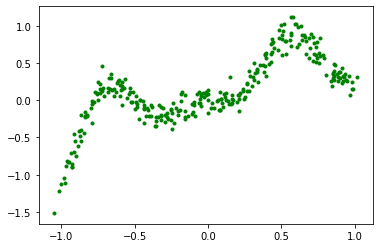

In [3]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [4]:
shdt = SoftHardDT(max_depth=3)
shdt.fit(xx, yy)

2
1
0
0
1
0
0


In [5]:
yout = shdt.predict(xx)

In [6]:
xx.shape, yout.shape

((300, 1), (300, 1))

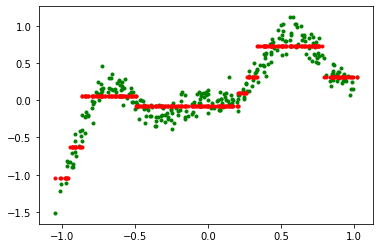

In [7]:
%matplotlib inline

plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), marker='.', color='r')
plt.show()

In [8]:
shdt.root.node_0, shdt.root.node_1

(<__main__.Decision_Node at 0x7f5684ab3d90>,
 <__main__.Decision_Node at 0x7f565708f110>)

In [9]:
# tree = shdt._get_best_split_(xx, yy)
# out = linear.forward(xx)
# y1 = (out>0)* c0
# y2 = (out<=0) * c1
# yout = y1+y2

In [10]:
# yout

## On 2D dataset

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
% matplotlib tk

In [12]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

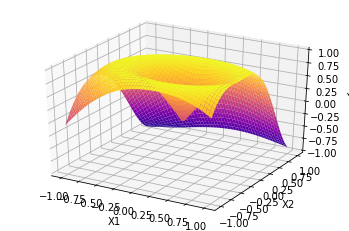

In [13]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [14]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [15]:
shdt = SoftHardDT(max_depth=4, min_samples=10, max_epochs=10000)
shdt.fit(xx, yy)

3
2
1
0
0
1
0
0
2
1
0
0
1
0
0


In [16]:
# %matplotlib inline
yout = shdt.predict(xx)

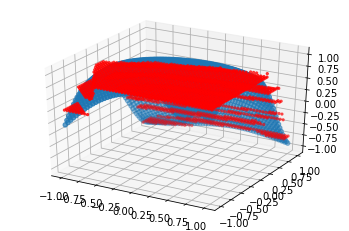

In [17]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

In [18]:
shdt.root.node_0

In [19]:
shdt.root.node_1

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
dtr = DecisionTreeRegressor(max_depth=4)

In [22]:
dtr.fit(xx, yy)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [23]:
yout = dtr.predict(xx)

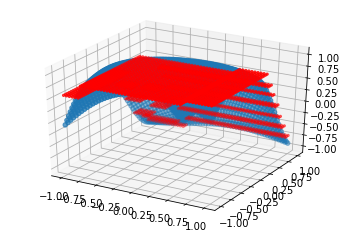

In [24]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()